**Mapping closure for $f_B$ in 1D using a Monte-Carlo Implementation**

This notebook introduces the mapping closure developed by (Chen, H. 1989, Pope, S.B. 1991) and discusses how it can be applied to the problem of turbulent scalar mixing. In contrast to these works which consider a one-point pdf, usually in the context of homogeneous isotropic turbulence, we consider the *global pdf* describing the contents of an arbitrary control volume.


**Content**

We first import all the packages we need to run this example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Evolution equation for the PDF**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial F}{\partial t} = -\mathbb{E}_Y[ \Gamma \nabla^2 Y ] \frac{\partial F}{\partial y},
\end{equation}

and

\begin{equation}
\frac{\partial f}{\partial t} = -\frac{\partial }{\partial y} \left( \mathbb{E}_Y[ \Gamma \nabla^2 Y ] f \right).
\end{equation}

As $f(y,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the mapping closure developed by [Pope et al. 1991](https://link.springer.com/article/10.1007/BF00271466) to estimate a closure for the molecular mixing terms.

The idea behind this closure relies on Gaussian random fields. What makes these "random" fields particularly useful is:
- They are completely defined by their mean and covariance: 
\begin{equation}
    \mu = \mathbb{E}[\theta(\mathbf{z})], \quad \rho(r) = \mathbb{E}[\theta(\mathbf{z})\theta(\mathbf{z} + \mathbf{e}r)] - \mu^2,
\end{equation}
- Allow the calculate explicity the conditional expectation
\begin{equation}
lim_{r \to 0} \frac{\partial^2 \rho(r)}{\partial r^2} = \left\langle \frac{\partial \theta}{\partial z_i} \frac{\partial \theta}{\partial z_i} \right\rangle,
\end{equation}

and the fact that multiple different field can have the same global PDF.


**Mapping Closure**

Based on the properties of the Gaussian random field the idea is therefore to find a mapping 
\begin{equation}
\tilde{Y}(\mathbf{x},t) = \mathscr{Y}(\theta(\mathbf{x} J(t)),t),
\end{equation}
such that we can express the CDF $F$ in terms of the cumulative Gaussian $G$ 
\begin{equation}
F(\mathscr{Y}(\eta,t),t) = G(\eta).
\end{equation}

Differentiating the last equation we obtain
\begin{equation}
\frac{ \partial F}{\partial t} = -\frac{ \partial \mathscr{Y}}{\partial t} \frac{ \partial F}{\partial y}.
\end{equation}
which can then be expressed as
\begin{equation}
\frac{\partial \mathscr{Y}}{\partial t} = \mathbb{E}_Y[ \Gamma \nabla^2 Y ] = \Gamma \underbrace{\frac{J^2(t)}{\lambda_{\theta}^2}}_{= 1/\tau} \left( \frac{\partial^2 \mathscr{Y} }{\partial \eta^2} - \eta \frac{\partial \mathscr{Y} }{\partial \eta} \right).
\end{equation}

**Particle Implementation**

Although we can solve this equation as a PDE on a grid using a standard method such as finite-difference it is also possible to use a particle method. Let $g(\eta)$ be the PDF of the random variable $\theta_t$ be generated an Ornstein-Uhlenbeck process:

\begin{equation}
  d \theta_{t} = -\frac{\theta_{t}}{T} d t +\left(\frac{1}{T} \right)^{1/2} d W_{t},
\end{equation}

and $Y_{t}=\mathscr{Y}(\theta_t,t)$, if follows from Ito's lemma implies that

\begin{equation}
  d Y_{t} = \frac{\partial \mathscr{Y}_{t} }{\partial t} dt + \frac{1}{T} \left( -\eta \frac{\partial \mathscr{Y}_{t}}{\partial \eta} + \frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^{2}} \right) dt + \frac{\partial \mathscr{Y}_{t}}{\partial \eta} \left( \frac{1}{T} \right)^{1/2} d W_{t},
\end{equation}

where $\eta$ is the sample-space (or dummy) variable corresponding to the random variable $\theta_t$. Setting $T = \tau = 1$ and substituting for $\frac{\partial \mathscr{Y}_{t} }{\partial t}$ then gives the full system as

\begin{align*} 
 d \theta_{t} &= -\theta_{t} d t + d W_{t},\\
 d \mathscr{Y}(\theta_{t} , t) &= \left( -\eta \partial_{\eta} \mathscr{Y} + \partial^2_{\eta} \mathscr{Y} \right) dt + \left( \partial_{\eta} \mathscr{Y} \right) d W_{t},
\end{align*}

where it is understood that derivatives are to be evaluated at $\eta = \theta_t$.

To determine $Y_t = \mathscr{Y}(\theta_t,t)$ and its derivatives requires that $F_Y(\mathscr{Y}(\eta,t),t) = G(\eta)$ is satisfied. Solving for the inverse CDF $F^{-1}_Y(p,t)$ we can determine

\begin{equation}
\mathscr{Y}(\eta,t) = F^{-1}_Y( G(\eta), t),
\end{equation}

as a function of $\eta$. Differentiating $F(\mathscr{Y}(\eta,t),t) = G(\eta)$ then gives 

\begin{equation}
\frac{\partial \mathscr{Y}_{t}}{\partial \eta} = \frac{g(\eta)}{f_Y(\mathscr{Y}(\eta,t),t)},
\end{equation}

which differentiated again respect to $\eta$ gives

\begin{equation}
\frac{\partial^2 \mathscr{Y}_{t}}{\partial \eta^2} = - \eta \frac{g}{f_Y} - \frac{g}{f^2_Y} \frac{\partial f_Y}{\partial y} \frac{\partial \mathscr{Y}_{t}}{\partial \eta} = - \frac{g}{f_Y} \left( \eta  +  \frac{\partial f_Y}{\partial y} \frac{g}{f^2_Y} \right),
\end{equation}

an expression that is a function of $g, f_Y$ and $\eta$ only.

Substituting for the derivatives in terms of $g,f_Y$ then gives

\begin{align*} 
 d \theta_{t} &= -\theta_{t} d t + d W_{t},\\
 d \mathscr{Y}(\theta_{t} , t) &= \left( \frac{g}{f_Y} \right) \left( \left[ -2 \theta_{t}  -  \frac{\partial f_Y}{\partial y} \frac{g}{f^2_Y} \right] dt + d W_{t} \right),
\end{align*}


In [2]:
import os,sys
sys.path.append(os.path.abspath("../../"))

from fft_kde import fft_kde
from scipy.interpolate import interp1d

def density(X):
    """
    Computes the kernel density estimate of the input data X using FFT.
    Args:
        X (np.ndarray): Input data points for which to compute the density estimate.
    Returns:
        f_X_interp (RegularGridInterpolator): Interpolated density estimate function.
        x_grid (np.ndarray): Grid points corresponding to the density estimate.
    """

    x_grid = np.linspace(np.min(X), np.max(X), len(X))
    f_X = fft_kde(X_points=X, x_grid=x_grid, h=0.1, kernel_type='gaussian', L=1.0)

    f_X_interp = interp1d(x_grid, f_X, kind='linear')

    return f_X_interp, x_grid

def density_derivative(f_interp, x_grid):
    """
    Computes the derivative of the interpolated density function and returns its interpolant.
    Args:
        f_interp (interp1d): Interpolated density function.
        x_grid (np.ndarray): Grid points corresponding to the density estimate.
    Returns:
        df_dx_interp (interp1d): Interpolated derivative of the density function.
    """
    f_values = f_interp(x_grid)
    df_dx = np.gradient(f_values, x_grid)
    df_dx_interp = interp1d(x_grid, df_dx, kind='linear')

    return df_dx_interp

In [3]:
import matplotlib.pyplot as plt

def plot_density(g, θ_grid, f, y_grid):
    """
    Plots the densities g(θ) and f(Y) on two subplots.

    Parameters:
    g (array-like): Density values for θ.
    θ_grid (array-like): Grid points for θ.
    f (array-like): Density values for Y.
    y_grid (array-like): Grid points for Y.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot g(θ)
    axs[0].plot(θ_grid, g(θ_grid), label='g(θ)', color='blue')
    axs[0].set_title('Density g(θ)')
    axs[0].set_xlabel('θ')
    axs[0].set_ylabel('Density')
    axs[0].legend()
    axs[0].grid(True)

    # Plot f(Y)
    axs[1].plot(y_grid, f(y_grid), label='f(Y)', color='green')
    axs[1].set_title('Density f(Y)')
    axs[1].set_xlabel('Y')
    axs[1].set_ylabel('Density')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

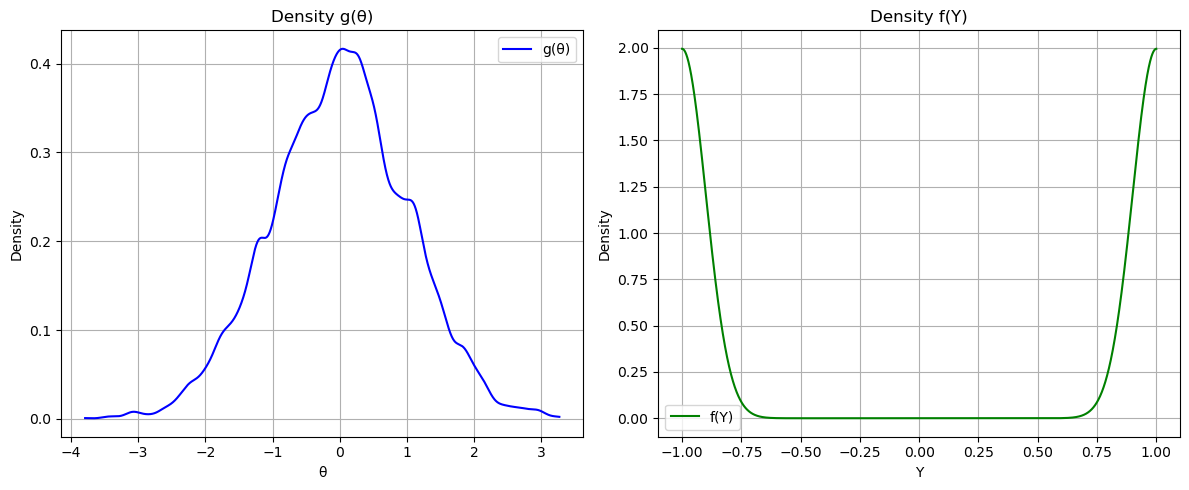

t = 1.000000e-01 



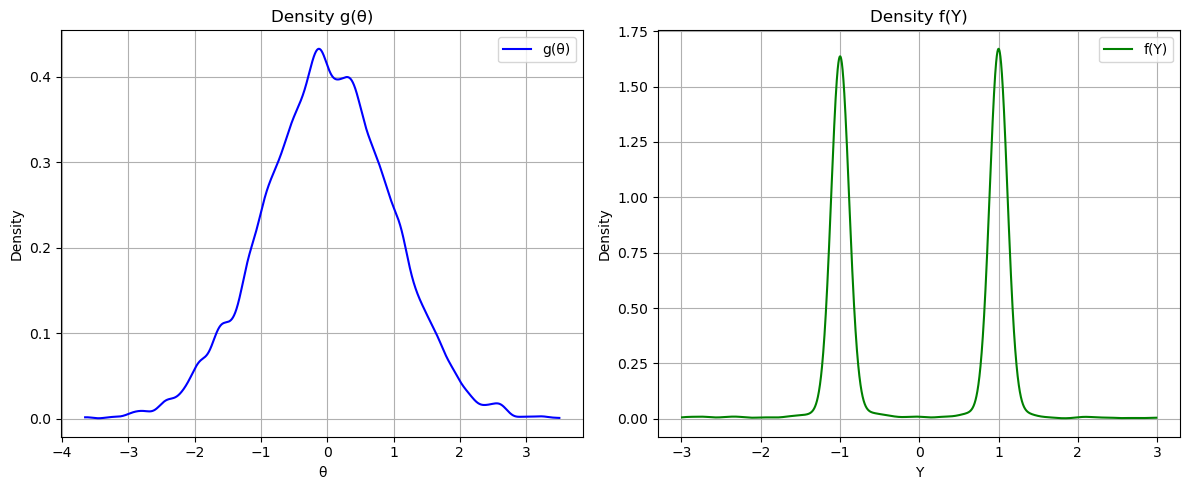

t = 2.000000e-01 



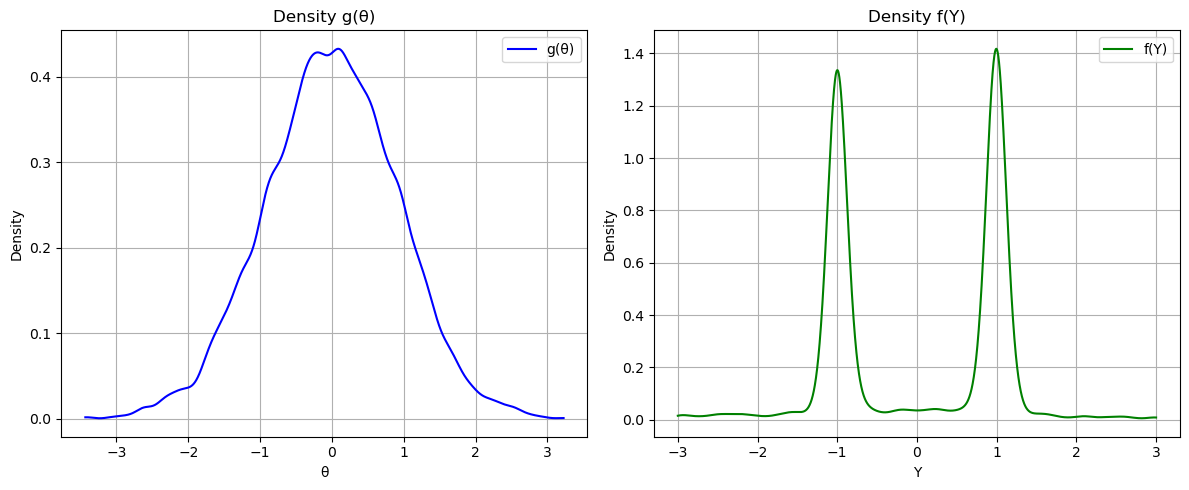

t = 3.000000e-01 



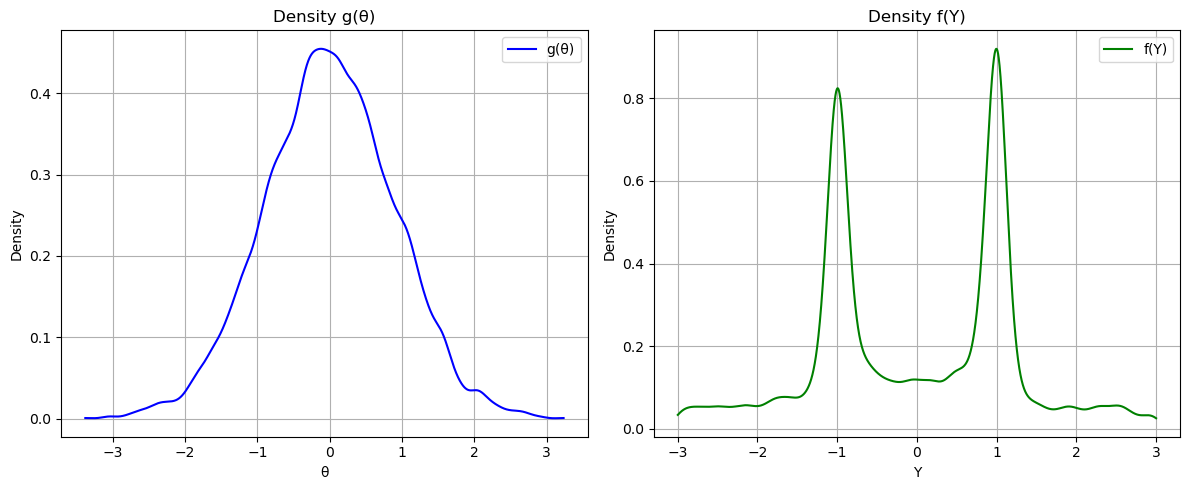

t = 4.000000e-01 



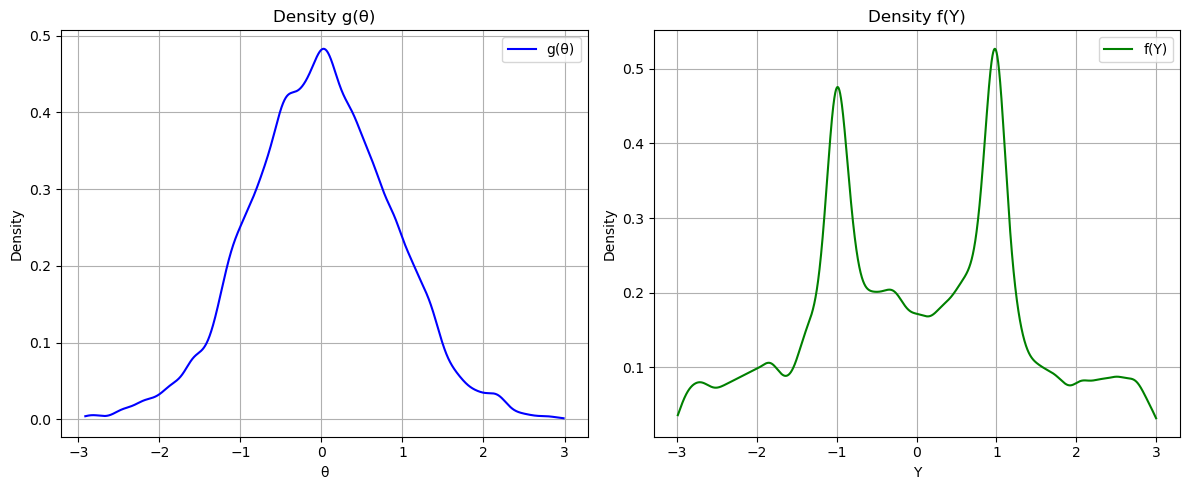

t = 5.000000e-01 



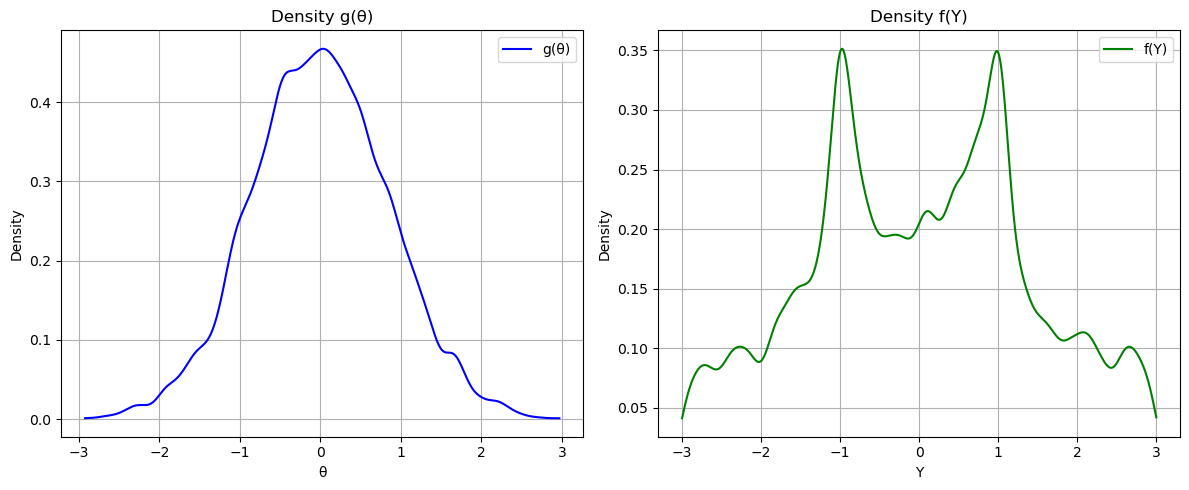

KeyboardInterrupt: 

In [4]:
from scipy.stats import norm

# Parameters
num_particles = 2**12  # Number of Monte Carlo samples
num_steps = 10**4     # Time steps
dt = 1e-04        # Time step size

Y_min = -3
Y_max =  3

# Brownian increments
dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps))  

# Container
θ = np.zeros((num_particles, num_steps))
Y = np.zeros((num_particles, num_steps))

# Initial conditions
θ[:,0] = np.random.normal(0, 1, num_particles) 

# Initial condition (Normal distribution)
#Y[:,0] = np.random.normal(0, 1e-03, num_particles)  

# Half of the particles to +1 and the other to -1
Y[:num_particles//2,0] = 1
Y[num_particles//2:,0] =-1

# Calculate derivatives
g, θ_grid = density(θ[:,0])
f, y_grid = density(Y[:,0])
plot_density(g, θ_grid, f, y_grid)


# Euler Maruyama
for n in range(1, num_steps):

    if n % (num_steps/10) == 0:
        print('t = %e \n'%(n*dt))
        # Calculate density and derivatives
        g, θ_grid = density(θ[:,n-1])
        f, y_grid = density(Y[:,n-1])
        plot_density(g, θ_grid, f, y_grid)

    # Calculate density and derivatives
    g, θ_grid = density(θ[:,n-1])
    f, y_grid = density(Y[:,n-1])
    g_vals = g(θ[:,n-1])
    f_vals = f(Y[:,n-1])
    
    df = density_derivative(f, y_grid)
    df_vals = df(Y[:,n-1])

    # Update particles
    θ[:, n] = θ[:, n-1] - θ[:, n-1] * dt  +  dW_t[:,n-1]
    
    # Avoid division by zero or instability
    g_vals = np.clip(g_vals, 1e-6, 1e2)
    f_vals = np.clip(f_vals, 1e-6, 1e2)
    
    # Compute drift and diffusion terms for Y
    drift     =-(g_vals / f_vals) * (2 * θ[:, n-1] + df_vals *( g_vals / (f_vals**2) ))
    diffusion = (g_vals / f_vals) * dW_t[:,n-1]

    # limit large drift
    mask = np.abs(drift) < 1e3  
    drift = np.where(mask, drift, 0.0)
    diffusion = np.where(mask, diffusion, 0.0)
    
    Y[:, n] = Y[:, n-1] + drift * dt + diffusion
    
    # Apply Reflecting/bcs
    Y[:, n] = np.where(Y[:, n] > Y_max, Y_max - (Y[:, n] - Y_max), Y[:, n]) # Reflect back inside
    Y[:, n] = np.where(Y[:, n] < Y_min, Y_min + (Y_min - Y[:, n]), Y[:, n]) # Reflect back inside



# # Estimate the probability density function at final time step using KDE
# b_values = np.linspace(-1.2, 1.2, 100)
# kde = gaussian_kde(b[:, -1])
# pdf_values = kde(b_values)

# # Plot the Monte Carlo histogram and estimated density
# plt.figure(figsize=(8, 5))
# plt.hist(b[:, -1], bins=50, density=True, alpha=0.6, label="Monte Carlo Histogram")
# plt.plot(b_values, pdf_values, 'r-', label="Kernel Density Estimation (KDE)")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.title("Monte Carlo Solution of Fokker-Planck")
# plt.legend()
# plt.show()